# Performance of Inception-v3

In [8]:
% matplotlib inline

import os
import matplotlib.pyplot as plt
from snntoolbox.core.util import wilson_score

from tests.other.googlenet.util import ExpResults, get_std, get_op_at_err

## Parameters and definitions

In [9]:
log_dir = '/home/rbodo/.snntoolbox/data/imagenet/inceptionV3/keras/log'
runlabel_analog = '03'
path_analog = os.path.join(log_dir, 'gui', runlabel_analog, 'log_vars')

clamp = 470 - 1

scale = 1e3  # Scale from Million to Billion operations

## Performance of ANN

In [10]:
# Error and number of operations
num_samples = 273
top1err_ANN = 100 - 79.12
top1std_ANN = get_std(top1err_ANN)
top1_confidence95_ANN = wilson_score(1-top1err_ANN/100, num_samples) * 100
top5err_ANN = 100 - 92.67
top5std_ANN = get_std(top5err_ANN)
top5_confidence95_ANN = wilson_score(1-top5err_ANN/100, num_samples) * 100
c_ANN = 11426432192 / 1e9

## Plot number of operations vs time

In [11]:
exp_analog = ExpResults(path_analog, 'SNN', '-.', scale=scale)
experiments = [exp_analog]

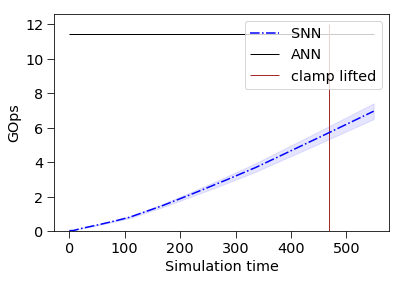

In [12]:
for exp in experiments:
    plt.plot(exp.time, exp.mean_computations_t, exp.marker, color=exp.color1, markersize=exp.markersize, label=exp.label)
    plt.fill_between(exp.time, exp.mean_computations_t-exp.std_computations_t, exp.mean_computations_t+exp.std_computations_t, alpha=0.1, color=exp.color1)
plt.hlines(c_ANN, 0, experiments[0].time[-1], linewidth=1, label='ANN')
plt.vlines(clamp, 0, 12, linewidth=1, label='clamp lifted', colors='brown')
plt.ylabel('GOps')
plt.xlabel('Simulation time')
plt.legend()
plt.ylim(0, None)
plt.savefig(os.path.join(log_dir, 'ops_vs_t'), bbox_inches='tight')

## Plot error vs time

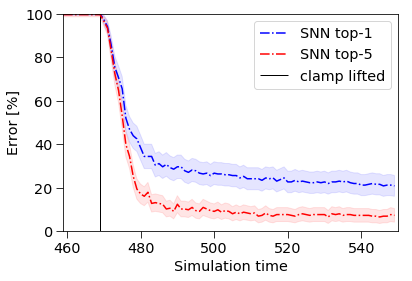

In [13]:
for exp in experiments:
    plt.plot(exp.time, exp.e1_mean, exp.marker, color=exp.color1, markersize=exp.markersize, label=exp.label+' top-1')
    plt.fill_between(exp.time, exp.e1_mean-exp.e1_confidence95, exp.e1_mean+exp.e1_confidence95, alpha=0.1, color=exp.color1)
    plt.plot(exp.time, exp.e5_mean, exp.marker, color=exp.color5, markersize=exp.markersize, label=exp.label+' top-5')
    plt.fill_between(exp.time, exp.e5_mean-exp.e5_confidence95, exp.e5_mean+exp.e5_confidence95, alpha=0.1, color=exp.color5)
plt.vlines(clamp, 0, 100, linewidth=1, label='clamp lifted')
plt.ylabel('Error [%]')
plt.xlabel('Simulation time')
plt.xlim(clamp-10, 550)
plt.ylim(0, 100)
plt.legend()
plt.savefig(os.path.join(log_dir, 'err_vs_t'), bbox_inches='tight')

## Plot error vs operations

In [15]:
op1_1 = get_op_at_err(experiments[0].mean_computations_t, experiments[0].e1_mean, top1err_ANN + 1)
op1_2 = get_op_at_err(experiments[0].mean_computations_t, experiments[0].e1_mean, top1err_ANN + 2)
op5_1 = get_op_at_err(experiments[0].mean_computations_t, experiments[0].e5_mean, top5err_ANN + 1)
op5_2 = get_op_at_err(experiments[0].mean_computations_t, experiments[0].e5_mean, top5err_ANN + 2)
print("SNN reaches within 1% of ANN top-1 (top-5) error after {:.2f} ({:.2f}) GOps.".format(op1_1, op5_1))

SNN reaches within 1% of ANN top-1 (top-5) error after 6.82 (6.28) GOps.


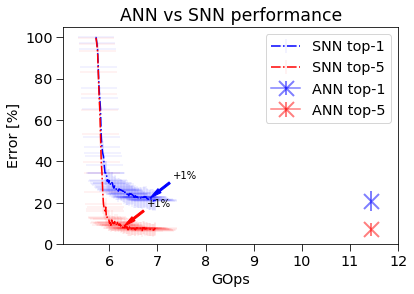

In [18]:
exp = experiments[0]

plt.errorbar(exp.mean_computations_t[clamp:], exp.e1_mean[clamp:], xerr=exp.std_computations_t[clamp:],
             yerr=exp.e1_confidence95[clamp:], fmt=exp.marker, label=exp.label+' top-1', capsize=0, elinewidth=0.1, color=exp.color1)
plt.errorbar(exp.mean_computations_t[clamp:], exp.e5_mean[clamp:], xerr=exp.std_computations_t[clamp:],
             yerr=exp.e5_confidence95[clamp:], fmt=exp.marker, label=exp.label+' top-5', capsize=0, elinewidth=0.1, color=exp.color5)

plt.errorbar(c_ANN, top1err_ANN, marker='x', label='ANN top-1', color=exp.color1, markersize=15,
             yerr=top1_confidence95_ANN, elinewidth=2, capthick=2, markeredgewidth=2, alpha=0.5)
plt.errorbar(c_ANN, top5err_ANN, marker='x', label='ANN top-5', color=exp.color5, markersize=15,
             yerr=top5_confidence95_ANN, elinewidth=2, capthick=2, markeredgewidth=2, alpha=0.5)

plt.annotate('+1%', xy=(op1_1, top1err_ANN+1), xytext=(op1_1 + 0.5, top1err_ANN + 11),
             arrowprops=dict(color=exp.color1, shrink=0.05, width=2, headwidth=5))
plt.annotate('+1%', xy=(op5_1, top5err_ANN+1), xytext=(op5_1 + 0.5, top5err_ANN + 11),
             arrowprops=dict(color=exp.color5, shrink=0.05, width=2, headwidth=5))

plt.ylim(0, 105)
plt.xlim(None, 12)
plt.ylabel('Error [%]')
plt.xlabel('GOps')
plt.legend(loc='upper right')
plt.title('ANN vs SNN performance')
plt.savefig(os.path.join(log_dir, 'err_vs_ops'), bbox_inches='tight')